# Egg-box Likelihood with Uniform Prior

This is a toy model shows how Nested Sampling easily handles likelihoods with multimodal behaviour.

$L(x) = P(y | x) = (2. + \prod_i cos(\frac{\theta_i}{2})))^5$

and

$P(x) = \mathcal{U}[x \mid 0, 10]$.


In [1]:
import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp
from jax import vmap

from jax.config import config

# Needed because otherwise likelihoods hit numerical plateau
config.update("jax_enable_x64", True)

from jaxns import DefaultNestedSampler
from jaxns import Model
from jaxns import Prior
from jaxns import bruteforce_evidence

tfpd = tfp.distributions

INFO[2023-12-21 13:21:27,547]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-21 13:21:27,548]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-21 13:21:27,549]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
WARNING[2023-12-21 13:21:27,549]: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:


ndim = 2


def log_likelihood(theta):
    return jnp.power(2. + jnp.prod(jnp.cos(0.5 * theta)), 5)


def prior_model():
    x = yield Prior(tfpd.Uniform(low=jnp.zeros(ndim), high=jnp.pi * 10 * jnp.ones(ndim)), name='theta')
    return x


model = Model(prior_model=prior_model,
              log_likelihood=log_likelihood)

log_Z_true = bruteforce_evidence(model=model, S=250)
print(f"True log(Z)={log_Z_true}")


True log(Z)=236.0483738381629


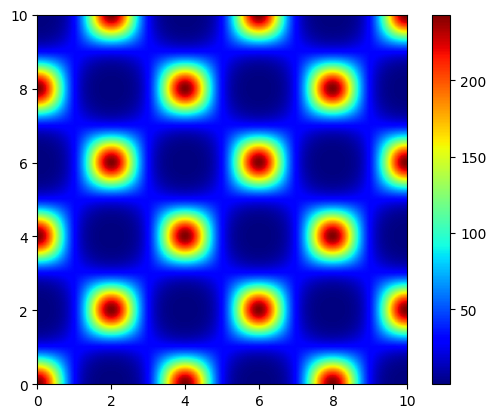

In [3]:
u_vec = jnp.linspace(0., 1., 250)
args = jnp.stack([x.flatten() for x in jnp.meshgrid(*[u_vec] * model.U_ndims, indexing='ij')], axis=-1)

# The `prepare_func_args(log_likelihood)` turns the log_likelihood into a function that nicely accepts **kwargs
lik = vmap(model.forward)(args).reshape((u_vec.size, u_vec.size))

plt.imshow(lik, origin='lower', extent=(0., 10., 0., 10.), cmap='jet')
plt.colorbar()
plt.show()

In [4]:


# Create the nested sampler class. In this case without any tuning.
ns = DefaultNestedSampler(model=model, max_samples=1e5, difficult_model=True)

termination_reason, state = ns(random.PRNGKey(42))
results = ns.to_results(termination_reason=termination_reason, state=state)


In [5]:
# We can use the summary utility to display results
ns.summary(results)

--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 198281
samples: 3000
phantom samples: 1300
likelihood evals / sample: 66.1
phantom fraction (%): 43.3%
--------
logZ=235.97 +- 0.29
H=-6.1
ESS=216
--------
theta[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
theta[0]: 12.2 +- 8.6 | 0.1 / 12.6 / 25.1 | 18.8 | 18.8
theta[1]: 16.0 +- 7.2 | 6.3 / 12.6 / 25.2 | 18.8 | 18.8
--------


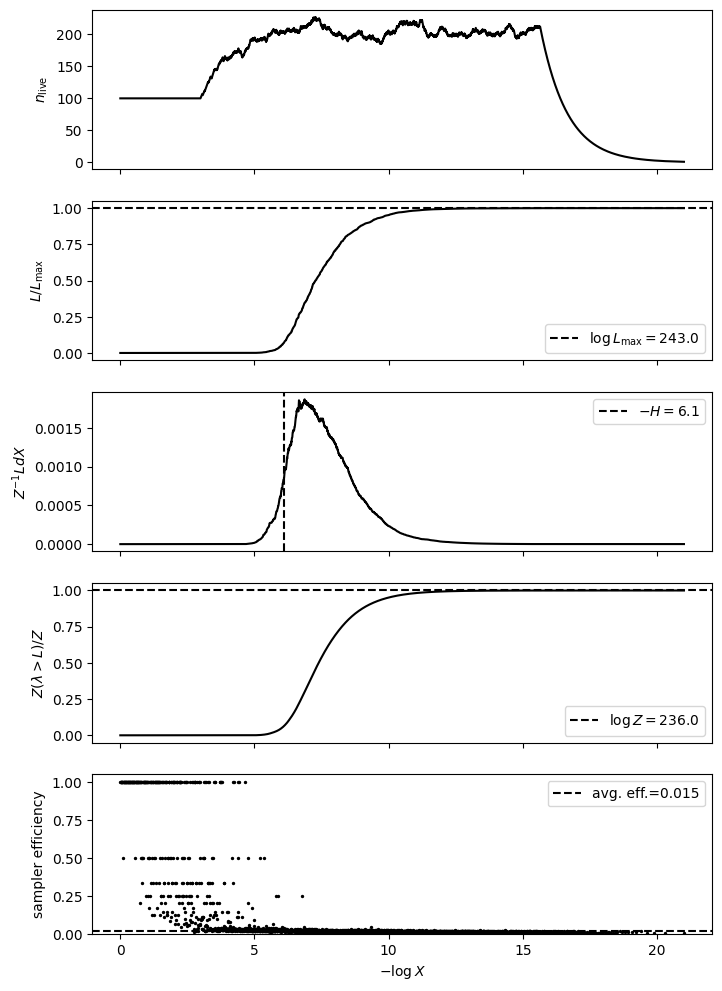

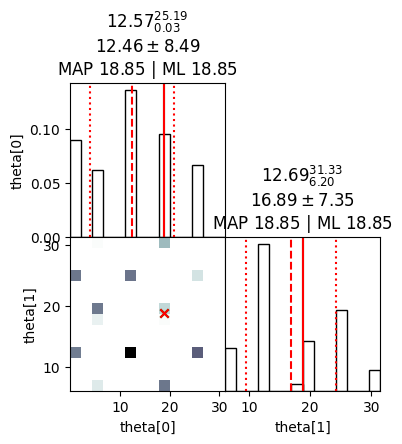

In [6]:

# We plot useful diagnostics and a distribution cornerplot
ns.plot_diagnostics(results)
ns.plot_cornerplot(results)